In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(r'C:\Users\USER\Documents\GitHub\DLOCT\cGAN_subsampling\Functions')
from numpy.fft import fftshift,ifft,fft
from scipy.signal import hilbert
from Deep_Utils import Correlation, MPS_single, Powerspectrum
from scipy.optimize import curve_fit
from tqdm import tqdm
import plotly.express as px
def extract_dimensions(file_name):
    parts = file_name.split('_')
    dimensions = []
    for part in parts:
        if 'z=' in part or 'x=' in part or 'y=' in part:
            number = int(part.split('=')[-1])
            dimensions.append(number)
    return tuple(dimensions)

def read_tomogram(file_path, dimensions):
    depth, height, width = dimensions
    with open(file_path, 'rb') as file:
        tomogram = np.fromfile(file, dtype='single')
        tomogram = tomogram.reshape((depth, height, width),order='F')
    return tomogram

def read_tomogram2(file_path, dimensions):
    depth, height, width = dimensions
    with open(file_path, 'rb') as file:
        tomogram = np.fromfile(file, dtype='single')
        tomogram = tomogram.reshape((depth, height, width))
    return tomogram

def dbscale(darray):
    if len(np.shape(darray))==3:
        img = 10*np.log10(abs(darray[:,:,0]+1j*darray[:,:,1])**2)
    else:
        img = 10*np.log10(abs(darray[:,:])**2)
    return img

def logScale(slices):
    
    logslices = np.copy(slices)
    nSlices = slices.shape[2]
    logslicesAmp = abs(logslices[:, :, :, 0] + 1j*logslices[:, :, :, 1])
    # and retrieve the phase
    logslicesPhase = np.angle(logslices[:, :, :, 0] + 1j*logslices[:, :, :, 1])
    print('maximum phase',logslicesPhase[:,:,0].max())
    print('minimun phase',logslicesPhase[:,:,0].min())
    # reescale amplitude
    logslicesAmp = np.log10(logslicesAmp)
    slicesMax = np.reshape(logslicesAmp.max(axis=(0, 1)), ( 1, 1,nSlices))
    slicesMin = np.reshape(logslicesAmp.min(axis=(0, 1)), ( 1, 1,nSlices))
    logslicesAmp = (logslicesAmp - slicesMin) / (slicesMax - slicesMin)
    # --- here, we could even normalize each slice to 0-1, keeping the original
    # --- limits to rescale after the network processes
    # and redefine the real and imaginary components with the new amplitude and
    # same phase
    logslices[:, :, :, 0] = (np.real(logslicesAmp * np.exp(1j*logslicesPhase)) + 1)/2
    logslices[:, :, :, 1] = (np.imag(logslicesAmp * np.exp(1j*logslicesPhase)) + 1)/2
    
    return logslices, slicesMax, slicesMin

def inverseLogScale(oldslices, slicesMax, slicesMin):
 
    slices = np.copy(oldslices)
    slices = (slices * 2) - 1
    slicesAmp = abs(slices[:, :, :, 0] + 1j*slices[:, :, :, 1])
    slicesPhase = np.angle(slices[:, :, :, 0] + 1j*slices[:, :, :, 1])
    slicesAmp = slicesAmp * (slicesMax - slicesMin) + slicesMin
    slicesAmp = 10**(slicesAmp)
    slices[:, :, :, 0] = np.real(slicesAmp * np.exp(1j*slicesPhase))
    slices[:, :, :, 1] = np.imag(slicesAmp * np.exp(1j*slicesPhase))
    return slices

def inverseLogScaleSummary(oldslices, slicesMax, slicesMin):
 
    slices = np.copy(oldslices)
    slices = (slices * 2) - 1
    slicesAmp = abs(slices[ :, :, 0] + 1j*slices[ :, :, 1])
    slicesPhase = np.angle(slices[ :, :, 0] + 1j*slices[ :, :, 1])
    slicesAmp = slicesAmp * (slicesMax - slicesMin) + slicesMin
    slicesAmp = 10**(slicesAmp)
    slices[:, :, 0] = np.real(slicesAmp * np.exp(1j*slicesPhase))
    slices[:, :, 1] = np.imag(slicesAmp * np.exp(1j*slicesPhase))
    return slices

In [2]:
pathcomplex = r'E:\DLOCT\Experimental_Data_complex\tomogram_artifacts\depth_nail'
artifact_files = os.listdir(pathcomplex)
for imag_file, real_file in zip(artifact_files[::2], artifact_files[1::2]):
        real_file_path = os.path.join(pathcomplex, real_file)
        imag_file_path = os.path.join(pathcomplex, imag_file)
        dimensions = extract_dimensions(real_file[:-4])
        tomReal = read_tomogram(real_file_path, dimensions)
        tomImag = read_tomogram(imag_file_path, dimensions)
        tomcc = np.stack((tomReal,tomImag),axis=3)
        del tomImag, tomReal
        tomcc = tomcc[360:664,:,:,:]
pathcomplex = r'E:\DLOCT\Experimental_Data_complex\tomogram_no_artifacts\depth_nail'
artifact_files = os.listdir(pathcomplex)
for imag_file, real_file in zip(artifact_files[::2], artifact_files[1::2]):
        real_file_path = os.path.join(pathcomplex, real_file)
        imag_file_path = os.path.join(pathcomplex, imag_file)
        dimensions = extract_dimensions(real_file[:-4])
        tomReal = read_tomogram(real_file_path, dimensions)
        tomImag = read_tomogram(imag_file_path, dimensions)
        tom = np.stack((tomReal,tomImag),axis=3)
        del tomImag, tomReal
        tom = tom[360:664,:,:,:]
print('experimental loaded')
tomcc2 = ifft(tom[:,:,:,0]+1j*tom[:,:,:,1],axis=0)
tomcc2 = fft(tomcc2.real,axis=0)
tomcc2 = np.stack((tomcc2.real,tomcc2.imag),axis=3)

experimental loaded


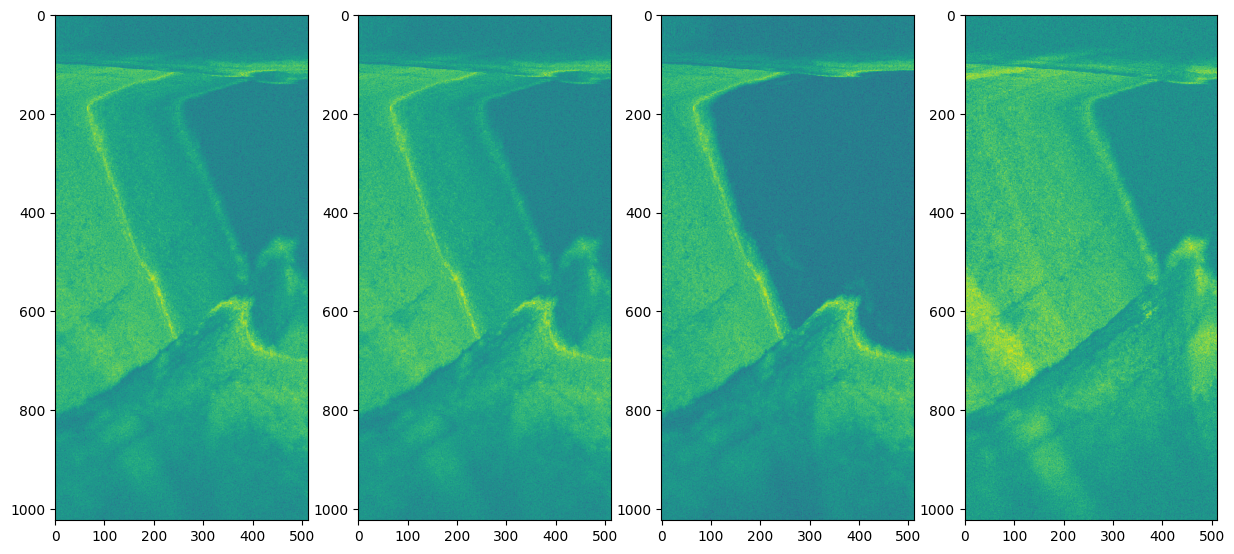

In [22]:
n = 200
n2 = 104
fig,axs = plt.subplots(ncols=4,nrows=1,figsize=(15,10))
axs[0].imshow(dbscale(tomcc2[n2,:,:,:]))
axs[1].imshow(dbscale(tomcc2[n,:,:,:]))
axs[2].imshow(dbscale(tom[n2,:,:,:]))
axs[3].imshow(dbscale(tom[n,:,:,:]))


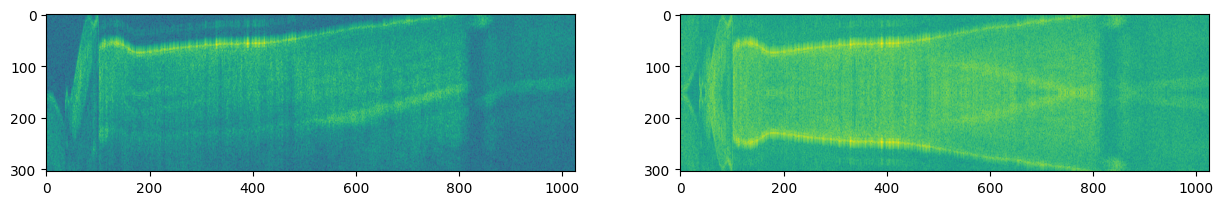

In [11]:
n = 0
fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(15,10))
axs[0].imshow(dbscale(tom[:,:,n,:]))
axs[1].imshow(dbscale(tomcc2[:,:,n,:]))

In [19]:
tomcc.shape

(304, 1024, 512, 2)